In [1]:
import pandas as pd
import yfinance as yf
import os
import sys

sys.path.append(os.getcwd()[:-10])
from kalman_filter import *
from utils.performance_metrics import *

### Grid searching for hyperparameter tuning

In the first notebook, we discussed the basic ideas of a serial position spread mean reversion strategy, from finding hedge ratios using Kalman filter to creating positions via Bollinger bands.

The next idea is to tune hyperparameters. While there are many industrial methods (e.g optuna), we'll use a simple grid search for this project.

In [2]:
security_1 = 'MSFT'
security_2 = 'V'
tickers = [security_1, security_2]

train_data = yf.download(tickers=tickers,
                            start='2010-01-01',
                            end='2017-01-01')['Adj Close']

train_data = train_data[tickers]

[*********************100%***********************]  2 of 2 completed


In [3]:
gridsearch_results = grid_search(price_data=train_data,
                                 strategy=kalman_filter_strategy,
                                 hyperparameters={'learning_rate': [5e-4, 3e-4,1e-4,7e-5,5e-5,3e-5,1e-5],
                                                  'covariance': [1e-3,7e-4,5e-4,3e-4,1e-4],
                                                  'zscore_threshold': [1.5, 2, 2.5, 3]},
                                 commissions_in_percent=0.25,
                                 bid_ask_spread=0.01)

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:05<00:00, 27.34it/s]


In [4]:
gridsearch_results.sort_values('sharpe_ratio', ascending=False).head()

,learning_rate,covariance,zscore_threshold,annual_returns,sharpe_ratio
28,0.0003,0.0010,3.0,0.029,7.177
85,0.0003,0.0003,3.0,0.029,7.177
120,0.0003,0.0005,3.0,0.029,7.177
129,0.0003,0.0001,3.0,0.029,7.177
124,0.0003,0.0007,3.0,0.029,7.177


In [5]:
gridsearch_results.sort_values('annual_returns', ascending=False).head()

,learning_rate,covariance,zscore_threshold,annual_returns,sharpe_ratio
43,0.00005,0.0007,1.5,0.105,1.339
118,0.00005,0.0010,1.5,0.105,1.350
1,0.00003,0.0005,2.0,0.103,1.351
56,0.00005,0.0005,1.5,0.101,1.297
137,0.00003,0.0007,2.0,0.101,1.335


### Observations

There is an obvious trade-off between sharpe ratios and annual returns. For strategies with very high sharpe ratios, these values are inflated due to the extremely small number of trades made; the strategy is playing it too safe and losing out on opportunities.

Let's use iteration #118 for our out-of-sample test

In [6]:
test_data = yf.download(tickers=tickers,
                        start='2017-01-01',
                        end='2020-01-01')['Adj Close']

test_data = test_data[tickers]

[*********************100%***********************]  2 of 2 completed


Annual returns: 0.093
Sharpe ratio: 3.272


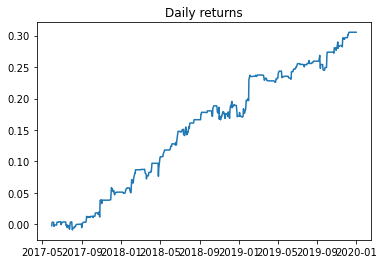

In [7]:
tuned_parameters = gridsearch_results.loc[118]

positions, hedge_ratios = kalman_filter_strategy(price_data=test_data,
                                                 learning_rate=tuned_parameters.learning_rate,
                                                 covariance=tuned_parameters.covariance,
                                                 zscore_threshold=tuned_parameters.zscore_threshold)

annual_returns, sharpe_ratio =\
    calculate_pnl_with_transaction_costs(price_data = test_data,
                                         positions = positions,
                                         portfolio_ratios = hedge_ratios,
                                         commissions_in_percent = 0.25,
                                         bid_ask_spread = 0.01)

print(f"Annual returns: {annual_returns}")
print(f"Sharpe ratio: {sharpe_ratio}")

### Observations

Surprisingly, the test results seem to outperform the training results! This is rare, as out-of-sample performance tends to be worse than in-sample. 

This could simply be a stroke of luck; so one should follow up with an events-based backtest and paper trading to evaluate strategy performance in more realistic scenarios.

### Improvements

Vectorised backtests tend to inflate strategy performance due to numerous simplifying assumptions made. Since we are solving a highly simplified problem, it should not come as a surprise that the results are better too.

Although the results above seem promising, an events-based backtest is necessary to improve statistical significance of results. 

Other improvements include:

- Volume sampling: using volume clock rather than human time clock to capture information uniformly.
- Johansen tests / ADF tests: hypothesis testing for stationarity, and trade only when we are confident that spread is truly stationary.
- Halflife calculations: The core of any mean reversion strategy, this measures the speed at which prices revert to their mean. One should setup timestops based on halflife calculations, to cut loss when prices do not revert as fast as expected.
- Rolling windows: Using a rolling window allows us to capture short term relationship as long term ones are rare. This works better with more granular data (events-based).
- Johansen / CADF methods: getting hedge ratios on a rolling window allows us to build spreads based on short term relationships, but works only with more granular data.
- Triple barrier method: Recommended by Marcos López de Prado, provides a framework for taking profits, cutting losses and hitting timestops.